In [1]:
# Cell 1: Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
# Cell 2: Model parameters (you can tune these)
params = {
    # Car / environment
    "m": 798.0,          # kg (F1 minimum car+driver mass around this range; using as typical)
    "rho": 1.225,        # kg/m^3 (air density at sea level)
    "Cd": 0.90,          # drag coefficient (effective)
    "A": 1.50,           # m^2 (frontal area)

    # Rolling resistance
    "Crr": 0.015,        # rolling resistance coefficient (rough)

    # Powertrain / traction limits
    "P_max": 735000.0,   # W (~1000 hp ≈ 745 kW; set 735 kW as round)
    "F_max": 16000.0,    # N traction/force cap at low speed (simplified)

    # Simulation
    "t_end": 10.0,       # seconds
    "dt": 0.01,          # time step
    "v0": 0.0            # initial speed m/s
}
params

{'m': 798.0,
 'rho': 1.225,
 'Cd': 0.9,
 'A': 1.5,
 'Crr': 0.015,
 'P_max': 735000.0,
 'F_max': 16000.0,
 't_end': 10.0,
 'dt': 0.01,
 'v0': 0.0}

In [3]:
g = 9.81

def F_drag(v, p):
    return 0.5 * p["rho"] * p["Cd"] * p["A"] * v**2

def F_roll(p):
    return p["Crr"] * p["m"] * g

def F_drive(v, p, eps=0.1):
    return min(p["F_max"], p["P_max"] / max(v, eps))

def dvdt(t, v, p):
    v = max(v, 0.0)
    Fnet = F_drive(v, p) - F_drag(v, p) - F_roll(p)
    return Fnet / p["m"]

In [4]:
# Cell 4: Euler and RK4 integrators

def solve_euler(p):
    dt = p["dt"]
    t = np.arange(0, p["t_end"] + dt, dt)
    v = np.zeros_like(t)
    v[0] = p["v0"]

    for i in range(len(t)-1):
        v[i+1] = v[i] + dt * dvdt(t[i], v[i], p)
        v[i+1] = max(v[i+1], 0.0)

    return t, v

def solve_rk4(p):
    dt = p["dt"]
    t = np.arange(0, p["t_end"] + dt, dt)
    v = np.zeros_like(t)
    v[0] = p["v0"]

    for i in range(len(t)-1):
        ti, vi = t[i], v[i]

        k1 = dvdt(ti, vi, p)
        k2 = dvdt(ti + dt/2, vi + dt*k1/2, p)
        k3 = dvdt(ti + dt/2, vi + dt*k2/2, p)
        k4 = dvdt(ti + dt,   vi + dt*k3,   p)

        v[i+1] = vi + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)
        v[i+1] = max(v[i+1], 0.0)

    return t, v

In [5]:
# Cell 5: Run both methods + compute distance

t_e, v_e = solve_euler(params)
t_r, v_r = solve_rk4(params)

dt = params["dt"]
x_e = np.cumsum(v_e) * dt
x_r = np.cumsum(v_r) * dt

# Convert to km/h for nicer reading
v_e_kmh = v_e * 3.6
v_r_kmh = v_r * 3.6

(t_e[-1], v_r_kmh[-1], x_r[-1])

(np.float64(10.0),
 np.float64(327.1257674326531),
 np.float64(641.2855091743278))

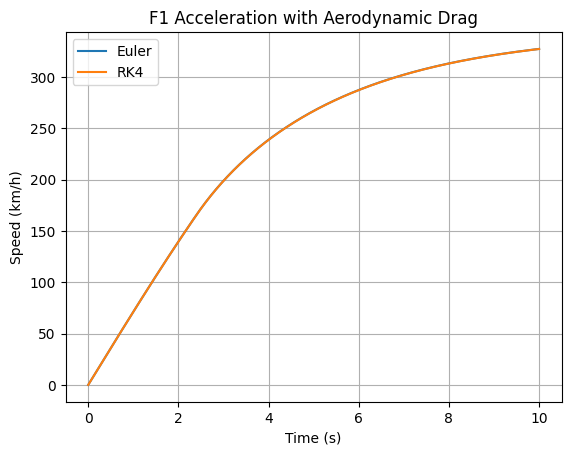

In [6]:
# Cell 6: Speed vs time
plt.figure()
plt.plot(t_e, v_e_kmh, label="Euler")
plt.plot(t_r, v_r_kmh, label="RK4")
plt.xlabel("Time (s)")
plt.ylabel("Speed (km/h)")
plt.title("F1 Acceleration with Aerodynamic Drag")
plt.grid(True)
plt.legend()
plt.show()

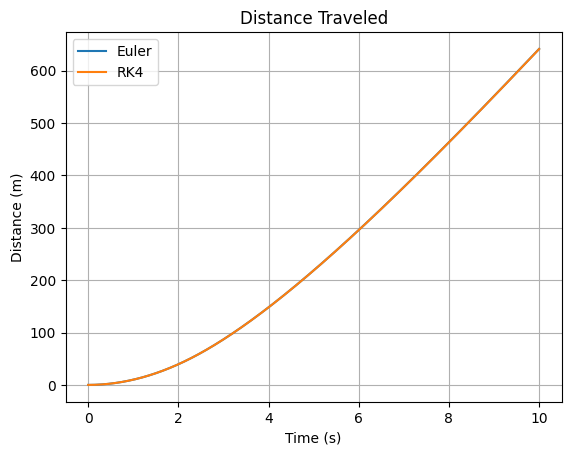

In [7]:
# Cell 7: Distance vs time
plt.figure()
plt.plot(t_e, x_e, label="Euler")
plt.plot(t_r, x_r, label="RK4")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.title("Distance Traveled")
plt.grid(True)
plt.legend()
plt.show()

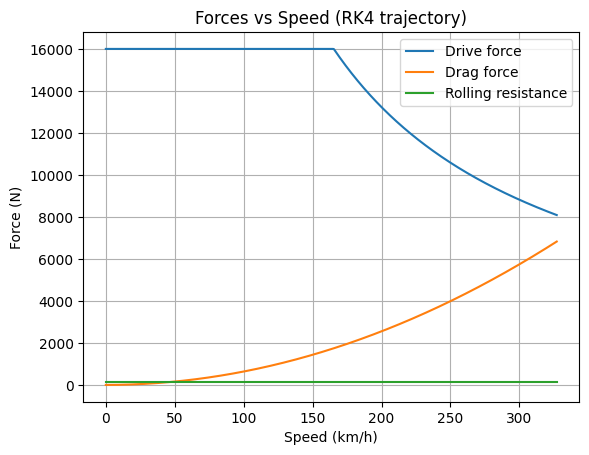

In [8]:
# Cell 8: Forces vs speed (RK4 trajectory)
Fdrive = np.array([F_drive(v, params) for v in v_r])
Fdrag  = np.array([F_drag(v, params) for v in v_r])
Froll  = F_roll(params) * np.ones_like(v_r)

plt.figure()
plt.plot(v_r_kmh, Fdrive, label="Drive force")
plt.plot(v_r_kmh, Fdrag,  label="Drag force")
plt.plot(v_r_kmh, Froll,  label="Rolling resistance")
plt.xlabel("Speed (km/h)")
plt.ylabel("Force (N)")
plt.title("Forces vs Speed (RK4 trajectory)")
plt.grid(True)
plt.legend()
plt.show()

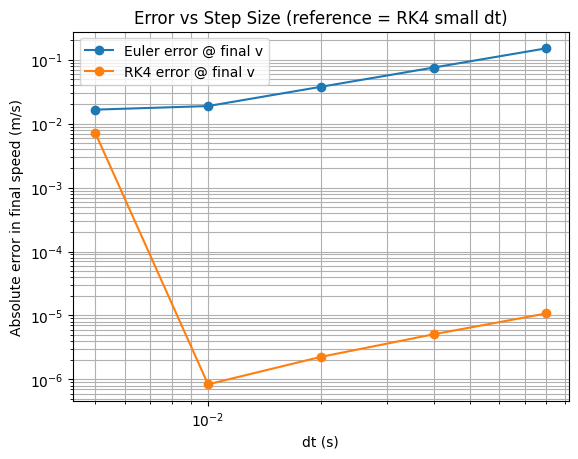

[(0.08, np.float64(0.150871847551727), np.float64(1.074520299937376e-05)),
 (0.04, np.float64(0.07541757316383269), np.float64(5.073448662074043e-06)),
 (0.02, np.float64(0.037704282886238616), np.float64(2.248919358294188e-06))]

In [9]:
# Cell 9: Step size study
def run_with_dt(dt):
    p = dict(params)
    p["dt"] = dt
    tE, vE = solve_euler(p)
    tR, vR = solve_rk4(p)
    return tE, vE, tR, vR

# Reference RK4 with small dt
dt_ref = 0.0005
p_ref = dict(params)
p_ref["dt"] = dt_ref
t_ref, v_ref = solve_rk4(p_ref)

# Interpolate reference speed to compare at the final time
v_ref_final = v_ref[-1]

dts = [0.08, 0.04, 0.02, 0.01, 0.005]
err_euler = []
err_rk4 = []

for dt_test in dts:
    tE, vE, tR, vR = run_with_dt(dt_test)
    err_euler.append(abs(vE[-1] - v_ref_final))
    err_rk4.append(abs(vR[-1] - v_ref_final))

err_euler = np.array(err_euler)
err_rk4 = np.array(err_rk4)

plt.figure()
plt.loglog(dts, err_euler, marker="o", label="Euler error @ final v")
plt.loglog(dts, err_rk4, marker="o", label="RK4 error @ final v")
plt.xlabel("dt (s)")
plt.ylabel("Absolute error in final speed (m/s)")
plt.title("Error vs Step Size (reference = RK4 small dt)")
plt.grid(True, which="both")
plt.legend()
plt.show()

list(zip(dts, err_euler, err_rk4))[:3]

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Reduce frames for smooth performance
stride = 5
t_anim = t_r[::stride]
x_anim = x_r[::stride]
v_anim = (v_r * 3.6)[::stride]   # km/h

fig, ax = plt.subplots()
ax.set_xlim(0, x_anim[-1]*1.05)
ax.set_ylim(-1, 1)
ax.set_yticks([])
ax.set_xlabel("Distance (m)")
ax.set_title("F1 Acceleration Animation (RK4)")

car, = ax.plot([], [], marker="o", markersize=12)
text = ax.text(0.02, 0.9, "", transform=ax.transAxes)

def init():
    car.set_data([], [])
    text.set_text("")
    return car, text

def update(i):
    x = x_anim[i]
    car.set_data([x], [0])
    text.set_text(f"t = {t_anim[i]:.2f}s | v = {v_anim[i]:.1f} km/h")
    return car, text

ani = FuncAnimation(fig, update, frames=len(t_anim), init_func=init, blit=True, interval=30)

plt.close(fig)  # prevents the blank static figure from showing
HTML(ani.to_jshtml())

In [ ]:
# ts aint it gng 